# TEXT to SQL: Using ML to generate structured queries from Natural Language

Capstone Project by Alberto Marengo

NOTE: This is Jupyter Notebook 3 of 6 for this project. The modeling part has been split into multiple notebooks because of the long running times.

In this notebook we are going to explore some classifier options offered in the `sklearn` package. The process will be as follow:

* Trying to predict only the first of the five targets (SELECT column) we will optimize:
    * the choice of the scaler
    * the choice of the dimensionality reduction
    * the best classifier and its hyperparameters
* Using the best estimator from above we will use a multioutput model to predict all the five targets

We are going to explore the following classifiers:

* [Logistic Regession](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
* [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html?highlight=svc#sklearn.svm.SVC)
* [Multinomial Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html?highlight=multinomialnb)
* [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=random%20forest#sklearn.ensemble.RandomForestClassifier)

For the multioutput model we are going to use [Classifier Chain](https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.ClassifierChain.html?highlight=classifier%20chain#sklearn.multioutput.ClassifierChain)

We will go more into detail in this notebook. 

Let's start loading the libraries!

In [1]:
import json
import nltk
from nltk.corpus import stopwords 
import string
import joblib

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns


from sklearn.feature_extraction.text import CountVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import ClassifierChain
from sklearn.metrics import accuracy_score, confusion_matrix


## Load the data

We are going to load the data (train, validation and test set) from the `.csv` files we created in notebook 1. 

In [2]:
X_train = pd.read_csv('processed_data/X_train.csv', index_col=0, squeeze=True)
y_train = pd.read_csv('processed_data/y_train.csv', index_col=0, squeeze=True)

X_val = pd.read_csv('processed_data/X_val.csv', index_col=0, squeeze=True)
y_val = pd.read_csv('processed_data/y_val.csv', index_col=0)

X_test = pd.read_csv('processed_data/X_test.csv', index_col=0, squeeze=True)
y_test = pd.read_csv('processed_data/y_test.csv', index_col=0)

## CountVectorizer

We are going to use `CountVectorizer` following the same procedure we used in notebook 2. For this reason we are not going to go into detail. 

In [3]:
stemmer = nltk.stem.PorterStemmer()

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
ENGLISH_STOP_WORDS = stopwords.words('english')

In [6]:
question_words_list = ['what', 'which','who', 'whom','when', 'where', 'why', 'how', 'with', 
                       'for', 'between', 'into', 'to','from', 'all', 'any', 'both', 'each' ]

In [7]:
 ENGLISH_STOP_WORDS = [word for word in ENGLISH_STOP_WORDS if word not in question_words_list]

In [8]:
def my_tokenizer(sentence):
    # remove punctuation and set to lower case
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    listofstemmed_words = []
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            # Stem words
            stemmed_word = stemmer.stem(word)
            listofstemmed_words.append(stemmed_word)

    return listofstemmed_words

In [9]:
bagofwords = CountVectorizer(min_df=5, tokenizer=my_tokenizer)

bagofwords.fit(X_train)

X_train_transformed = bagofwords.transform(X_train)
X_test_transformed = bagofwords.transform(X_test)

/opt/conda/envs/capstone/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


## Pipeline and GridSearchCV

One the the `question` is vectorized it's time to optimize the best [pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters.
The estimators that we are going to optimize are going to be a scaler, a dimension reduction and classifier.

For now we are going to create an `estimators` dictionary with some "place-holders" in order to instantiate the pipeline.

In [10]:
# Create the place-holder dictionary for the estimators
estimators = [('normalize', Normalizer()),
             ('reduce_dim', PCA()),
             ('model', SVC())]

# Instantiate the pipeline
pipeline = Pipeline(estimators)

Next we are going to create a `parameter_grid` with the estimators' hyperparameter values we want to optimize for. Below is a breakdown of what we are going to do.

As mentioned above we want to try for different models and their hyperparameters:

* Logistic Regression and `C` values of `0.001, 0.01, 0.1, 1, 10, 100`
* SVC and `C` values of `0.001, 0.01, 0.1, 1, 10, 100`
* Random Forest and:
    * `model__n_estimators`of `100, 200, 300, 500`
    * `model__max_depth` of `1, 2, 10, 50`
* Multinomial Naive Bayes and `alpha` of `0` and `1` 

For each of the model we also want to see how the model score behave if:

* apply/not apply `Normalizer` as a scaler
* apply/not apply `PCA`, the dimensionality reduction, keeping 90% of the explained variance(`n_components=0.9`)

In order to select the best model for all the above we are going to use sklearn's [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=grid%20search%20cv#sklearn.model_selection.GridSearchCV) which will perform an exhaustive search over the specified parameter values for the estimators. The parameters of the estimators are optimized by cross-validated grid-search over the parameter grid.

`GridSearchCV` is a very helpful tool that allows us to reduce the amount of code and visualization to find the best estimators. 

In this case we are going to set a 5-fold cross validation (`cv=5`) meaning that the `.score` of the model will be the mean of 5 different sub-samples (validation). `Grid_SearchCV` will return the best estimators base on this score being the highest among all the models.

**NOTE** the next cell takes a very long time to run given the huge amount of `.fit` and `.score` that we are asking for.

In [11]:
# Create the parametr grid
parameter_grid = [{'model': [SVC()],
                  'normalize': [Normalizer(), None],
                  'reduce_dim': [PCA(n_components=0.9), None],
                  'model__C': [0.001, 0.01, 0.1, 1, 10, 100]},
                  {'model': [RandomForestClassifier()],
                  'normalize': [None],
                  'reduce_dim': [PCA(n_components=0.9), None],
                  'model__n_estimators': [100, 200, 300, 500],
                  'model__max_depth': [1, 2, 10, 50]},
                  {'model': [LogisticRegression()],
                  'normalize': [Normalizer(), None],
                  'reduce_dim': [PCA(n_components=0.9), None],
                  'model__C': [0.001, 0.01, 0.1, 1, 10, 100]},
                  {'model': [MultinomialNB()],
                  'normalize': [Normalizer(), None],
                  'reduce_dim': [PCA(n_components=0.9), None],
                  'model__alpha': [0, 1]}
    
]

# Instantiate the GridSearchCV with 5-fold cross validation and using all the available cpus in parallel
grid = GridSearchCV(pipeline, parameter_grid, cv=5, verbose=100, n_jobs=-1)

# fit the grid on X_train and only the first output of y_trian
fitted_grid = grid.fit(X_train_transformed, y_train.iloc[:, 0])

Fitting 5 folds for each of 88 candidates, totalling 440 fits


/opt/conda/envs/capstone/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.16859758        nan 0.16859758        nan 0.17174428
        nan 0.18908687        nan 0.27150837        nan 0.26374892
        nan 0.33749943        nan 0.33226083        nan 0.34549154
        nan 0.33742809        nan 0.34180849        nan 0.31999615
        nan 0.18676262        nan 0.18429538        nan 0.18345496
        nan 0.18340134        nan 0.2092902         nan 0.21106006
        nan 0.21538672        nan 0.20880718        nan 0.26630586
        nan 0.26711033        nan 0.26866584        nan 0.26877325
        nan 0.32641455        nan 0.33081274        nan 0.33208216
        nan 0.33052666        nan 0.22525608        nan 0.23555418
        nan 0.24086416        nan 0.26612687        nan 0.27420809
        nan 0.28529293        nan 0.28373753        nan 0.27919635
        nan 0.27916067        nan 0.2707575

We can see that the `GridearchCV` went through 440 fits over 88 different combinations on 5 folds. 

Let's see what's the best estimator among all the candidates.

In [12]:
# Print the best estimator (pipeline)
fitted_grid.best_estimator_

Pipeline(steps=[('normalize', Normalizer()), ('reduce_dim', None),
                ('model', SVC(C=10))])

In [13]:
# Print the best set of parameters
fitted_grid.best_params_

{'model': SVC(C=10),
 'model__C': 10,
 'normalize': Normalizer(),
 'reduce_dim': None}

We can see that best pipeline is:

* scaler: `Normalizer()`
* dimensionality reduction: `None`
* model: `SVC()` with `C=10`

Let's have a look on how this model performs (scores) on the `test` and on the `train` set.

In [14]:
# Print the score on test set
fitted_grid.score(X_test_transformed, y_test.iloc[:, 0])

0.39201117673207597

In [15]:
# Print the score on test set
fitted_grid.score(X_train_transformed, y_train.iloc[:, 0])

0.983766001573339

We see that the the model is overfitted because the accuracy on `train` set is $98$% compared to the $39$% on the `test` set. The two numbers are too far apart, that means that the model learned very well (it's closely fit) on the training set but struggles when is given inputs that has never seen before. The model it's too "specific" for the training set.

Now that we have the best estimator we can try to predict all the outputs (5 columns of the queries) in sequence.

## Build the Regressor Chain

In order to implement a multioutput model we are going to use the [Classifier Chain](https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.ClassifierChain.html#sklearn.multioutput.ClassifierChain) which is a multi-label model that arranges classifiers into a chain. Each model makes a prediction in the order specified by the chain using all of the available features provided to the model plus the predictions of models that are earlier in the chain.

Below is a a sketch of the pipeline to fit the model on the `train` set and how it works.

<img src='figures/Classifier_Chain.jpg' width=1000 height=1000/>


We are going to apply a scaler first, the `Normalizer()`.

In [16]:
# Instantiate the scaler
normalizer = Normalizer()

# Fit the normalizer on the vectorized X_trian
normalizer.fit(X_train_transformed)

# Transform X_train and X_test
X_train_norm = normalizer.transform(X_train_transformed)
X_test_norm = normalizer.transform(X_test_transformed)

We are now going to instantiate the `Classifier Chain` using `SVC` with `C=10`, the best estimator from the `GridSearchCV`. We are also passing the hyperparameters `probability=True` which allows to predict probabilities when the model is fit and saved.

In [17]:
# Instantiate the Classifier Chain
class_chain = ClassifierChain(base_estimator=SVC(C=10, probability=True))

# Fit the Classifier Chain on X_train normalized and y_train (5 outputs)
class_chain.fit(X_train_norm, y_train)

ClassifierChain(base_estimator=SVC(C=10, probability=True))

Let's also have a look at what the predictions for the 5 outputs look like and let's get the accuracies of each output on the `test` set.

In [18]:
test_pred = class_chain.predict(X_test_norm)
test_pred

array([[3., 0., 1., 0., 1.],
       [4., 0., 0., 0., 1.],
       [0., 0., 2., 0., 3.],
       ...,
       [4., 3., 2., 0., 0.],
       [4., 0., 3., 0., 0.],
       [2., 0., 4., 0., 2.]])

## Results

In [19]:
print(f"Test Accuracy Select column: {accuracy_score(y_test.iloc[:, 0], test_pred[:, 0])}")
print(f"Test Accuracy Agg column: {accuracy_score(y_test.iloc[:, 1], test_pred[:, 1])}")
print(f"Test Accuracy first where column: {accuracy_score(y_test.iloc[:, 2], test_pred[:, 2])}")
print(f"Test Accuracy second where column: {accuracy_score(y_test.iloc[:, 3], test_pred[:, 3])}")
print(f"Test Accuracy third where column: {accuracy_score(y_test.iloc[:, 4], test_pred[:, 4])}")

Test Accuracy Select column: 0.39201117673207597
Test Accuracy Agg column: 0.8768019305264495
Test Accuracy first where column: 0.3395567409665333
Test Accuracy second where column: 0.9143963929637391
Test Accuracy third where column: 0.5194640248936305


We notice that the accuracy on the `Agg` column and `second where column` are quite good (87% and 91%) because the model had fewer classes to chose from, 5 and 3 respectively.

All the other outputs, where the classes are 10 to 11, have lower accuracies (39%, 33% and 51%).

Because of the class imbalance we have in all the outputs, accuracy is not the best metric for the problem. We are now going to have a look at the confusion matrix of each output.

In [20]:
# Create an empty dictionary
conf_mat_dict = {}

# Create a confusion matrix for each output
for i in range(5): 
    conf_mat = confusion_matrix(y_test.iloc[:, i], test_pred[:, i])
    # Append the matrix to the dictionary
    conf_mat_dict[i] = conf_mat

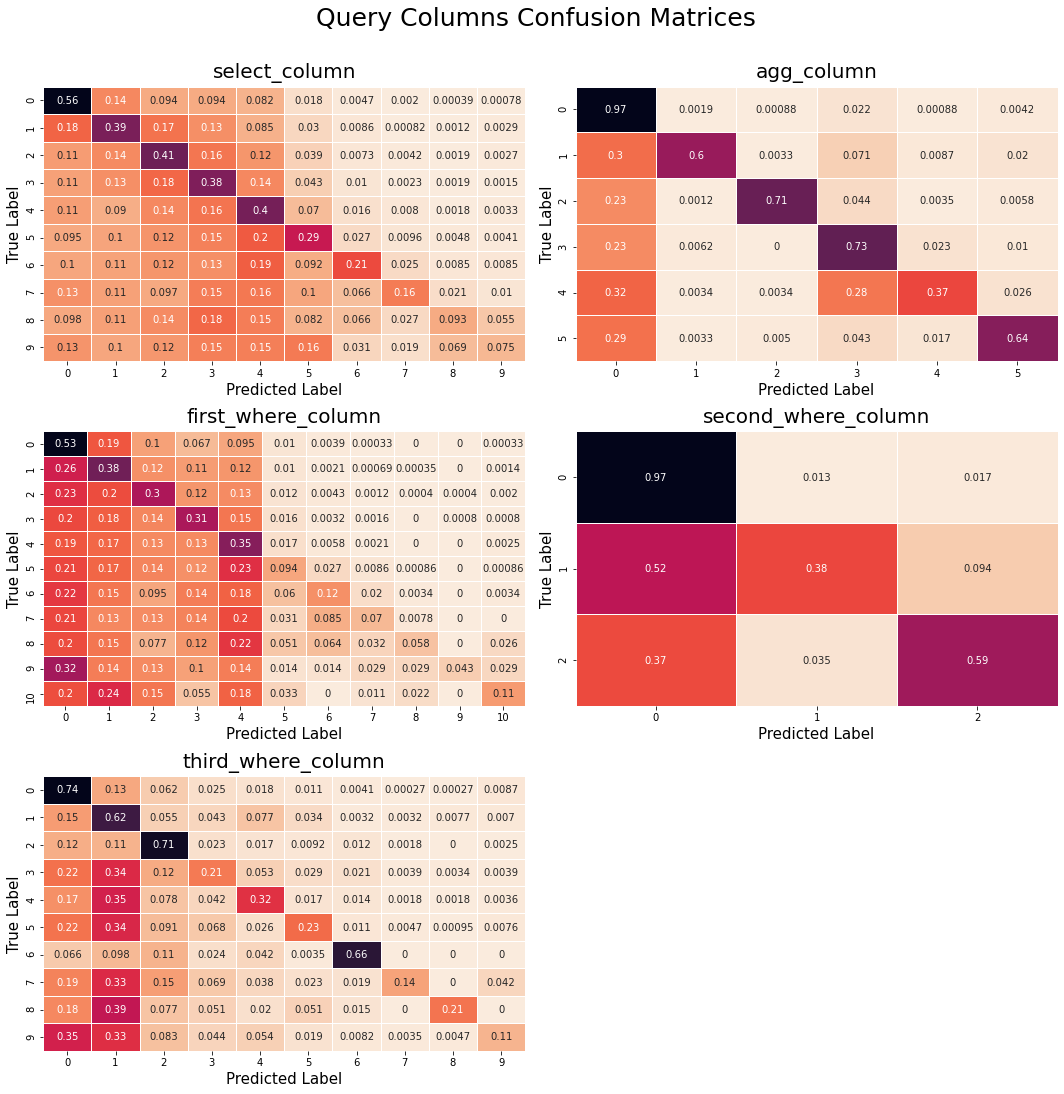

In [21]:
# Create the list of column names
columns = ['select_column', 'agg_column', 'first_where_column', 'second_where_column', 'third_where_column']
# Create the figure and the axes array 
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
# Flatten the axes from a 3x2 to a 6x1
ax = ax.flatten()

# Plot the confusion matrices
for i in range(5):
    conf_mat = conf_mat_dict[i]
    # Normalize the confusion matrix along the 'predicted' columns
    normalized_conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
    sns.heatmap(normalized_conf_mat,
                        annot=True,
                        cbar=False,
                        cmap="rocket_r",
                        linewidths=1, ax=ax[i]
                       )
    # Set the title, x and y labels
    ax[i].set_title(columns[i], size = 20,y=1.01)
    ax[i].set_xlabel("Predicted Label", size = 15)
    ax[i].set_ylabel("True Label", size = 15)

# Plot the title of the figure
fig.suptitle("Query Columns Confusion Matrices", size = 25, y=1.01)
fig.tight_layout()

# Delete the last subplot
fig.delaxes(ax[-1])

As suspected, the class imbalance have a good influence on the predictions of the models. 

The higher the numbers (close to 1) along the diagonal the better the model is performing. For this `Classifier Chain` we see some good performance on some of the classes but also some pretty bad one on others. If we look at the class distribution we can correlate the result. The model predict very well classes that are more frequent in the `train` set but has a hard time to predict less frequent classes.

Let's save the model using `joblib`.

In [22]:
joblib.dump(class_chain, "seq2sql_class.joblib")

['seq2sql_class.joblib']

This is the end of Jupyter Notebook 3 of 6. In the next one we'll explore Deep Learning and we'll try Recurrent Neural Networks (RNN) to approach this problem.